# 🔋 EV Charging Station Optimization & Profit Prediction 🔋

## My company is looking for investing in EV Charging Stations in Shenzhen, China. They want to build 3 new stations. My job is to help them, given the locations and performance of the current working stations, find uncovered spots within the city. 

## Using a rich dataset of existing EV infrastructure including demand (volume), pricing (electricity & service fees), site metadata, weather, and geographic information we aim to:

### - 📍 Locate underserved areas within Shenzhen where EV charging stations are sparse but demand is potentially high (high demand - low supply) 
### - 🧠 Analyze historical performance of existing stations to understand what drives high usage and profitability.
### - 📈 Predict future station performance, including:
####      Revenue and costs (electricity and service fees)
####      Profitability per hour/day/month
####      Return on Investment (ROI)

## Goals: 

### 1. Find suitable locations to place a EV Charging station in Shenzhen, China. HOW? 🧐:
#### Find uncovered urban areas with high residential or commercial activity
#### Low competition zones with sparse existing station density (based on distance between charging stations)

### 2. 🌧 Weather-dependent patterns (do people charge more when it’s rainy or cold? or they rather stay at home?)
### 3. High-volume stations’s traits to generalize success factors (what makes the other stations profitable?) How?:
####   Find the financial metrics of each charging station to assess whether new stations would be profitable.
### 4. Clustering/prediction: 
#### 🏗 Construction cost? We will estimate fixed cost of building based on real Shenzhen figures
#### 🔌 Power capacity. Will new location handle expected demand?
#### 💵 Estimated demand & revenue
#### 📉 Risk modeling (sesitivity analysis). What if energy prices go up 📈 or demand drops 📉?

### 5. Business simulation. Best location proposal, ROI, time to break even



## What is the purpose?:
### Value for investors, urban planners, sustainability...


# What do we as Data Sciencists expect?
## We expect to find at least 6 optimal locations (my company is only able to build 3 stations)
## What will the approach be?:
### - Data Preprocessing: Clean and merge datasets
### - Exploratory Data Analysis: Understand trends, station utilization, and pricing structures
### - Location Analysis: Use geospatial data to find underserved areas
### - Predictive Modeling: Estimate volume, profit, and ROI for new sites using clustering and supervised ML models
### - Visualization: Maps and charts to communicate spatial and financial insights

# What data do we have?:
## Sites: Locations and metadata of 1379 real charging stations
## Volume & Duration: Hourly charging demand and session lengths
## E-Price & S-Price: Hourly electricity cost and service fees
## POIs: Points of Interest near stations (residential, commercial, cinema, parking...) using point of interest from OpenStreetMap
## Distance: Matrix of inter-site distances
## Weather: Hourly weather data from Visual Crossing API
## Pending to get: Population distribution map on coordinates 113.784724, 114.062996, 22.46557, 22.592883.

In [260]:
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import folium
import geopandas as gpd
from shapely.geometry import Point
import numpy as np

In [261]:
volume = pd.read_csv("volume.csv", parse_dates=True, index_col=0)
duration = pd.read_csv("duration.csv", parse_dates=True, index_col=0)
e_price = pd.read_csv("e_price.csv", parse_dates=True, index_col=0)
s_price = pd.read_csv("s_price.csv", parse_dates=True, index_col=0)
sites = pd.read_csv("sites.csv")

In [262]:
print(volume.shape)
print(duration.shape)
print(e_price.shape)
print(s_price.shape)
print(sites.shape)

(4392, 1379)
(4392, 1379)
(4392, 1379)
(4392, 1379)
(1379, 9)


In [263]:
print(sites.index.equals(sites.index))
print(sites.isna().sum().sum()) 

True
0


In [264]:
sites

,site,longitude,latitude,charger_num,total_duration,total_volume,avg_power,perimeter,area
0,0,114.142651,22.547750,4,77594.572675,5.431620e+05,7.000000,431.915270,12419.719390
1,1,114.119416,22.541244,1,9882.750000,6.917925e+04,7.000000,275.289766,6011.643662
2,3,114.109352,22.540594,1,5726.625000,4.014792e+04,7.003539,275.289079,6011.615355
3,4,114.116610,22.579000,1,100576.916667,7.040384e+05,7.000000,275.329698,6013.289655
4,5,114.114493,22.543569,1,32646.833333,2.285278e+05,7.000000,275.292222,6011.744920
...,...,...,...,...,...,...,...,...,...
1374,1440,114.086330,22.629165,1,197383.733393,3.463798e+07,175.920328,275.382891,6015.482062
1375,1441,114.026166,22.713154,1,188865.688114,2.458308e+07,129.459182,275.472296,6019.166627
1376,1442,113.944227,22.526603,1,19393.958333,6.787885e+04,3.500000,275.274304,6011.006324
1377,1443,114.055040,22.569144,1,13450.916667,4.707821e+04,3.500000,275.319265,6012.859638


In [265]:
volume.head()

,0,1,10,100,1000,1001,1002,1003,1004,1005,...,99,990,991,992,993,994,995,996,997,999
2023-04-01 00:00:00,48.416667,4.083333,1.166667,140.0,9.333333,5.25,100.916667,45.500000,8.750000,16.625000,...,3620.0,8.750000,4.083333,8.750000,25.083333,7.583333,19.250000,152.250000,2.041667,149.916667
2023-04-01 01:00:00,37.982671,1.166667,0.000000,140.0,9.333333,5.25,83.416667,42.583333,8.166667,12.833333,...,1240.0,8.166667,4.083333,5.541667,21.000000,6.416667,19.250000,151.083333,2.041667,148.750000
2023-04-01 02:00:00,40.382008,0.583333,0.000000,140.0,9.333333,5.25,68.833333,37.916667,8.166667,14.000000,...,3140.0,8.166667,4.083333,6.125000,16.333333,5.833333,16.333333,150.500000,2.041667,148.750000
2023-04-01 03:00:00,41.614679,0.000000,0.000000,140.0,9.333333,5.25,59.500000,37.916667,9.333333,13.708333,...,2920.0,8.750000,4.083333,6.416667,16.333333,5.250000,16.333333,151.666667,2.041667,148.750000
2023-04-01 04:00:00,40.514016,0.000000,0.000000,140.0,9.333333,5.25,74.083333,42.583333,8.166667,12.833333,...,3000.0,8.166667,4.083333,5.541667,19.250000,6.416667,19.250000,151.083333,2.041667,148.750000


In [266]:
site_0 = volume.columns[0]
site_0

'0'

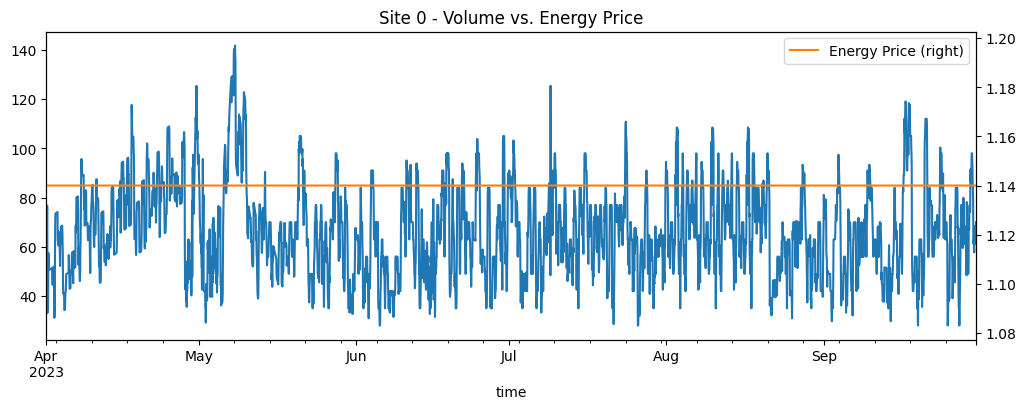

In [267]:
plt.figure(figsize=(12,4))
volume[site_0].plot(label="Volume (kWh)")
e_price[site_0].plot(label="Energy Price", secondary_y=True)
plt.title(f"Site {site_0} - Volume vs. Energy Price")
plt.legend()
plt.show()

In [268]:
for df in [volume, duration, e_price, s_price]:
    df.columns = df.columns.astype(str)

In [269]:
volume_long = volume.reset_index().melt(id_vars='index', var_name='site_id', value_name='volume')
duration_long = duration.reset_index().melt(id_vars='index', var_name='site_id', value_name='duration')
e_price_long = e_price.reset_index().melt(id_vars='time', var_name='site_id', value_name='e_price')
s_price_long = s_price.reset_index().melt(id_vars='time', var_name='site_id', value_name='s_price')

for df in [volume_long, duration_long]:
    df.rename(columns={'index': 'timestamp'}, inplace=True)
for df in [e_price_long, s_price_long]:
    df.rename(columns={'time': 'timestamp'}, inplace=True)

In [270]:
dfs = [volume_long, duration_long, e_price_long, s_price_long]

df_full = reduce(lambda left, right: pd.merge(left, right, on=['timestamp', 'site_id']), dfs)

In [271]:
df_full

,timestamp,site_id,volume,duration,e_price,s_price
0,2023-04-01 00:00:00,0,48.416667,6.916667,1.14,1.14
1,2023-04-01 01:00:00,0,37.982671,5.426096,1.14,1.14
2,2023-04-01 02:00:00,0,40.382008,5.768858,1.14,1.14
3,2023-04-01 03:00:00,0,41.614679,5.944954,1.14,1.14
4,2023-04-01 04:00:00,0,40.514016,5.787717,1.14,1.14
...,...,...,...,...,...,...
6056563,2023-09-30 19:00:00,999,151.643333,21.663333,0.00,0.00
6056564,2023-09-30 20:00:00,999,151.620000,21.660000,0.00,0.00
6056565,2023-09-30 21:00:00,999,151.596667,21.656667,0.00,0.00
6056566,2023-09-30 22:00:00,999,151.573333,21.653333,0.00,0.00


In [272]:
sites['site'] = sites['site'].astype(str)
df_full = df_full.merge(sites, left_on='site_id', right_on='site')

In [273]:
df_full.head()

,timestamp,site_id,volume,duration,e_price,s_price,site,longitude,latitude,charger_num,total_duration,total_volume,avg_power,perimeter,area
0,2023-04-01 00:00:00,0,48.416667,6.916667,1.14,1.14,0,114.142651,22.54775,4,77594.572675,543162.008724,7.0,431.91527,12419.71939
1,2023-04-01 01:00:00,0,37.982671,5.426096,1.14,1.14,0,114.142651,22.54775,4,77594.572675,543162.008724,7.0,431.91527,12419.71939
2,2023-04-01 02:00:00,0,40.382008,5.768858,1.14,1.14,0,114.142651,22.54775,4,77594.572675,543162.008724,7.0,431.91527,12419.71939
3,2023-04-01 03:00:00,0,41.614679,5.944954,1.14,1.14,0,114.142651,22.54775,4,77594.572675,543162.008724,7.0,431.91527,12419.71939
4,2023-04-01 04:00:00,0,40.514016,5.787717,1.14,1.14,0,114.142651,22.54775,4,77594.572675,543162.008724,7.0,431.91527,12419.71939


In [274]:
poi = pd.read_csv("poi.csv")
poi['type'].unique()

array(['other', 'fuel', 'fire_station', 'hospital', 'cinema',
       'restaurant', 'fast_food', 'bank', 'cafe', 'kindergarten', 'taxi',
       'parking', 'parking_entrance', 'conference_centre', 'toilets',
       'post_office', 'vending_machine', 'bus_station', 'bicycle_rental',
       'atm', 'marketplace', 'post_box', 'school', 'pharmacy',
       'nightclub', 'place_of_worship', 'bench', 'bar', 'pub',
       'ice_cream', 'fountain', 'charging_station', 'clinic', 'shelter',
       'library', 'car_rental', 'bicycle_parking', 'telephone',
       'recycling', 'waste_basket', 'doctors', 'police', 'border_control',
       'food_court', 'waste_disposal', 'karaoke_box', 'veterinary',
       'bureau_de_change', 'bread', 'college', 'townhall', 'arts_centre',
       'public_bath', 'drinking_water', 'ferry_terminal', 'lounge',
       'water_point', 'childcare', 'waste_transfer_station',
       'driving_school', 'hunting_stand', 'dentist', 'clock',
       'school gate', 'community_centre', 'cantee

In [275]:
print(df_full['longitude'].min(), df_full['longitude'].max())
print(df_full['latitude'].min(), df_full['latitude'].max())

113.784724 114.516991
22.46557 22.818918


In [276]:
# Here I reduce the dataset significantly narrowing the Shenzhen area (dataset coordenates are for Shenzhen province, now reduced to Shenzhen city)
bounding_boxes = [113.784724, 114.062996, 22.46557, 22.592883]

In [277]:
lat_min, lat_max = 22.46557, 22.592883
lon_min, lon_max = 113.784724, 114.062996
center_lat = (lat_min + lat_max) / 2
center_lon = (lon_min + lon_max) / 2

map_szx= folium.Map(location=[center_lat, center_lon], zoom_start=11)

folium.Rectangle(
    bounds=[[lat_min, lon_min], [lat_max, lon_max]],
    color="blue", fill=True, fill_opacity=0.1
).add_to(map_szx)

# Show the map
map_szx

In [278]:
df_full = df_full[df_full["latitude"].between(left=22.46557, right=22.592883)]
df_full = df_full[df_full["longitude"].between(left=113.784724, right=114.062996)]

In [279]:
df_full.reset_index(drop=True, inplace=True)
df_full

,timestamp,site_id,volume,duration,e_price,s_price,site,longitude,latitude,charger_num,total_duration,total_volume,avg_power,perimeter,area
0,2023-04-01 00:00:00,1001,5.250000,0.750000,0.0,0.0,1001,114.053016,22.522570,2,6454.951579,4.518466e+04,7.0,275.270048,6010.830856
1,2023-04-01 01:00:00,1001,5.250000,0.750000,0.0,0.0,1001,114.053016,22.522570,2,6454.951579,4.518466e+04,7.0,275.270048,6010.830856
2,2023-04-01 02:00:00,1001,5.250000,0.750000,0.0,0.0,1001,114.053016,22.522570,2,6454.951579,4.518466e+04,7.0,275.270048,6010.830856
3,2023-04-01 03:00:00,1001,5.250000,0.750000,0.0,0.0,1001,114.053016,22.522570,2,6454.951579,4.518466e+04,7.0,275.270048,6010.830856
4,2023-04-01 04:00:00,1001,5.250000,0.750000,0.0,0.0,1001,114.053016,22.522570,2,6454.951579,4.518466e+04,7.0,275.270048,6010.830856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2178427,2023-09-30 19:00:00,999,151.643333,21.663333,0.0,0.0,999,114.039323,22.550918,2,190767.416667,1.335372e+06,7.0,275.299989,6012.065070
2178428,2023-09-30 20:00:00,999,151.620000,21.660000,0.0,0.0,999,114.039323,22.550918,2,190767.416667,1.335372e+06,7.0,275.299989,6012.065070
2178429,2023-09-30 21:00:00,999,151.596667,21.656667,0.0,0.0,999,114.039323,22.550918,2,190767.416667,1.335372e+06,7.0,275.299989,6012.065070
2178430,2023-09-30 22:00:00,999,151.573333,21.653333,0.0,0.0,999,114.039323,22.550918,2,190767.416667,1.335372e+06,7.0,275.299989,6012.065070


In [280]:
distance = pd.read_csv('distance.csv')

In [281]:
distance.columns

Index(['Unnamed: 0', '0', '1', '3', '4', '5', '6', '7', '8', '9',
       ...
       '1434', '1436', '1437', '1438', '1439', '1440', '1441', '1442', '1443',
       '1444'],
      dtype='object', length=1380)

In [282]:
distance = distance.rename(columns={'Unnamed: 0': 'from_site_id'})

distance_long = distance.melt(id_vars='from_site_id', 
                                     var_name='to_site_id', 
                                     value_name='distance')
distance_long

,from_site_id,to_site_id,distance
0,0,0,0.000000
1,1,0,2.496200
2,3,0,3.515668
3,4,0,4.375921
4,5,0,2.933117
...,...,...,...
1901636,1440,1444,18.537879
1901637,1441,1444,27.970158
1901638,1442,1444,33.077632
1901639,1443,1444,21.127366


In [283]:
distance_long['from_site_id'] = distance_long['from_site_id'].astype(int)
distance_long['to_site_id'] = distance_long['to_site_id'].astype(int)

In [284]:
distance_long

,from_site_id,to_site_id,distance
0,0,0,0.000000
1,1,0,2.496200
2,3,0,3.515668
3,4,0,4.375921
4,5,0,2.933117
...,...,...,...
1901636,1440,1444,18.537879
1901637,1441,1444,27.970158
1901638,1442,1444,33.077632
1901639,1443,1444,21.127366


In [285]:
unique_sites_ids = df_full['site_id'].unique().astype(int)

In [286]:
distance_long = distance_long[
    distance_long['from_site_id'].isin(unique_sites_ids) &
    distance_long['to_site_id'].isin(unique_sites_ids)
]

In [287]:
unique_sites = df_full.drop_duplicates(subset='site_id')[['latitude', 'longitude']]
unique_sites

,latitude,longitude
0,22.522570,114.053016
4392,22.561905,114.016060
8784,22.562480,114.016557
13176,22.547534,114.044623
17568,22.546775,114.047172
...,...,...
2156472,22.531407,114.054828
2160864,22.590903,114.059013
2165256,22.591356,114.056366
2169648,22.536691,114.016845


In [288]:
for _, row in unique_sites.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color='blue',
        fill=True,
        fill_opacity=0.6
    ).add_to(map_szx)
map_szx

In [289]:
missing_price = df_full[(df_full['e_price'] == 0.0) | (df_full['s_price'] == 0.0)]
#print(f"{len(missing_price)} rows with 0 pricing out of {len(df_full)} total rows")
df_full

,timestamp,site_id,volume,duration,e_price,s_price,site,longitude,latitude,charger_num,total_duration,total_volume,avg_power,perimeter,area
0,2023-04-01 00:00:00,1001,5.250000,0.750000,0.0,0.0,1001,114.053016,22.522570,2,6454.951579,4.518466e+04,7.0,275.270048,6010.830856
1,2023-04-01 01:00:00,1001,5.250000,0.750000,0.0,0.0,1001,114.053016,22.522570,2,6454.951579,4.518466e+04,7.0,275.270048,6010.830856
2,2023-04-01 02:00:00,1001,5.250000,0.750000,0.0,0.0,1001,114.053016,22.522570,2,6454.951579,4.518466e+04,7.0,275.270048,6010.830856
3,2023-04-01 03:00:00,1001,5.250000,0.750000,0.0,0.0,1001,114.053016,22.522570,2,6454.951579,4.518466e+04,7.0,275.270048,6010.830856
4,2023-04-01 04:00:00,1001,5.250000,0.750000,0.0,0.0,1001,114.053016,22.522570,2,6454.951579,4.518466e+04,7.0,275.270048,6010.830856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2178427,2023-09-30 19:00:00,999,151.643333,21.663333,0.0,0.0,999,114.039323,22.550918,2,190767.416667,1.335372e+06,7.0,275.299989,6012.065070
2178428,2023-09-30 20:00:00,999,151.620000,21.660000,0.0,0.0,999,114.039323,22.550918,2,190767.416667,1.335372e+06,7.0,275.299989,6012.065070
2178429,2023-09-30 21:00:00,999,151.596667,21.656667,0.0,0.0,999,114.039323,22.550918,2,190767.416667,1.335372e+06,7.0,275.299989,6012.065070
2178430,2023-09-30 22:00:00,999,151.573333,21.653333,0.0,0.0,999,114.039323,22.550918,2,190767.416667,1.335372e+06,7.0,275.299989,6012.065070


In [290]:
avg_e_price = df_full[df_full['e_price'] > 0]['e_price'].mean()
avg_s_price = df_full[df_full['s_price'] > 0]['s_price'].mean()
print(avg_e_price,avg_s_price)

0.7710902054829318 0.7710902054829318


#### Some charging stations doesn't show e_price and s_price, I compute the average price to fill empty values

In [291]:
bins = [0, 6.9, 22, 60, 150]  # Approximate thresholds for AC slow, AC fast, DC fast, superchargers
labels = ['AC_slow', 'AC_fast', 'DC_fast', 'Ultra_fast']
df_full['power_class'] = pd.cut(df_full['avg_power'], bins=bins, labels=labels)
df_full

,timestamp,site_id,volume,duration,e_price,s_price,site,longitude,latitude,charger_num,total_duration,total_volume,avg_power,perimeter,area,power_class
0,2023-04-01 00:00:00,1001,5.250000,0.750000,0.0,0.0,1001,114.053016,22.522570,2,6454.951579,4.518466e+04,7.0,275.270048,6010.830856,AC_fast
1,2023-04-01 01:00:00,1001,5.250000,0.750000,0.0,0.0,1001,114.053016,22.522570,2,6454.951579,4.518466e+04,7.0,275.270048,6010.830856,AC_fast
2,2023-04-01 02:00:00,1001,5.250000,0.750000,0.0,0.0,1001,114.053016,22.522570,2,6454.951579,4.518466e+04,7.0,275.270048,6010.830856,AC_fast
3,2023-04-01 03:00:00,1001,5.250000,0.750000,0.0,0.0,1001,114.053016,22.522570,2,6454.951579,4.518466e+04,7.0,275.270048,6010.830856,AC_fast
4,2023-04-01 04:00:00,1001,5.250000,0.750000,0.0,0.0,1001,114.053016,22.522570,2,6454.951579,4.518466e+04,7.0,275.270048,6010.830856,AC_fast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2178427,2023-09-30 19:00:00,999,151.643333,21.663333,0.0,0.0,999,114.039323,22.550918,2,190767.416667,1.335372e+06,7.0,275.299989,6012.065070,AC_fast
2178428,2023-09-30 20:00:00,999,151.620000,21.660000,0.0,0.0,999,114.039323,22.550918,2,190767.416667,1.335372e+06,7.0,275.299989,6012.065070,AC_fast
2178429,2023-09-30 21:00:00,999,151.596667,21.656667,0.0,0.0,999,114.039323,22.550918,2,190767.416667,1.335372e+06,7.0,275.299989,6012.065070,AC_fast
2178430,2023-09-30 22:00:00,999,151.573333,21.653333,0.0,0.0,999,114.039323,22.550918,2,190767.416667,1.335372e+06,7.0,275.299989,6012.065070,AC_fast


In [292]:
df_full[['e_price', 's_price']] = df_full[['e_price', 's_price']].replace(0.0, pd.NA)

In [293]:
df_full.groupby('power_class')[['e_price', 's_price']].median()

/var/folders/sp/j31td69s1fsg02f7tz1kfv9m0000gn/T/ipykernel_4448/961729883.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_full.groupby('power_class')[['e_price', 's_price']].median()


,e_price,s_price
power_class,,
AC_slow,0.8,0.8
AC_fast,0.94,0.94
DC_fast,0.327415,0.327415
Ultra_fast,0.330003,0.330003


In [294]:
price_map = {
    'AC_slow': 0.7,
    'AC_fast': 0.9,
    'DC_fast': 1.3,
    'Ultra_fast': 1.7
}
for pc, price in price_map.items():
    df_full.loc[df_full['power_class'] == pc, 'e_price'] = price
    df_full.loc[df_full['power_class'] == pc, 's_price'] = price

In [295]:
df_full[df_full['power_class'] == 'AC_slow'].nunique()

timestamp          4392
site_id             114
volume            69937
duration          67646
e_price               1
s_price               1
site                114
longitude           114
latitude            114
charger_num           4
total_duration      109
total_volume        107
avg_power            45
perimeter           114
area                114
power_class           1
dtype: int64

In [296]:
df_full['revenue'] = df_full['volume'] * (df_full['e_price'] + df_full['s_price'])
df_full['cost'] = df_full['volume'] * df_full['e_price']
df_full['profit'] = df_full['revenue'] -  df_full['cost']
df_full.head()

,timestamp,site_id,volume,duration,e_price,s_price,site,longitude,latitude,charger_num,total_duration,total_volume,avg_power,perimeter,area,power_class,revenue,cost,profit
0,2023-04-01 00:00:00,1001,5.25,0.75,0.9,0.9,1001,114.053016,22.52257,2,6454.951579,45184.661052,7.0,275.270048,6010.830856,AC_fast,9.45,4.725,4.725
1,2023-04-01 01:00:00,1001,5.25,0.75,0.9,0.9,1001,114.053016,22.52257,2,6454.951579,45184.661052,7.0,275.270048,6010.830856,AC_fast,9.45,4.725,4.725
2,2023-04-01 02:00:00,1001,5.25,0.75,0.9,0.9,1001,114.053016,22.52257,2,6454.951579,45184.661052,7.0,275.270048,6010.830856,AC_fast,9.45,4.725,4.725
3,2023-04-01 03:00:00,1001,5.25,0.75,0.9,0.9,1001,114.053016,22.52257,2,6454.951579,45184.661052,7.0,275.270048,6010.830856,AC_fast,9.45,4.725,4.725
4,2023-04-01 04:00:00,1001,5.25,0.75,0.9,0.9,1001,114.053016,22.52257,2,6454.951579,45184.661052,7.0,275.270048,6010.830856,AC_fast,9.45,4.725,4.725


In [297]:
df_full['avg_power'].nunique()

81

In [298]:
site_999 = df_full[df_full['site_id'] == '999']
site_999['volume'].value_counts()

volume
155.750000    905
148.750000    484
151.666667     78
152.833333     63
162.750000     60
             ... 
151.444444      1
151.388889      1
151.222222      1
151.111111      1
151.573333      1
Name: count, Length: 2030, dtype: int64

In [299]:
( site_999['volume'] == 0 ).any()

False

In [300]:
site_1001 = df_full[df_full['site_id'] == '1001']
site_1001['volume'].value_counts()

volume
4.666667    2078
5.250000     468
4.083333      86
7.583333      20
5.833333      12
            ... 
5.478261       1
5.376812       1
5.275362       1
5.173913       1
4.844907       1
Name: count, Length: 1659, dtype: int64

In [301]:
df_full.loc[df_full['duration'] == 0][['volume','duration']].nunique()

volume      7
duration    1
dtype: int64

In [302]:
df_full.loc[df_full['duration'] == 0, 'volume'] = 0

In [303]:
df_full.loc[df_full['avg_power'] == 150]

,timestamp,site_id,volume,duration,e_price,s_price,site,longitude,latitude,charger_num,total_duration,total_volume,avg_power,perimeter,area,power_class,revenue,cost,profit
101016,2023-04-01 00:00:00,105,4200.0,28.000000,1.7,1.7,105,113.968312,22.565812,1,245280.00000,3.679200e+07,150.0,275.315740,6012.714318,Ultra_fast,14280.0,7140.0,7140.0
101017,2023-04-01 01:00:00,105,4200.0,28.000000,1.7,1.7,105,113.968312,22.565812,1,245280.00000,3.679200e+07,150.0,275.315740,6012.714318,Ultra_fast,14280.0,7140.0,7140.0
101018,2023-04-01 02:00:00,105,4200.0,28.000000,1.7,1.7,105,113.968312,22.565812,1,245280.00000,3.679200e+07,150.0,275.315740,6012.714318,Ultra_fast,14280.0,7140.0,7140.0
101019,2023-04-01 03:00:00,105,4200.0,28.000000,1.7,1.7,105,113.968312,22.565812,1,245280.00000,3.679200e+07,150.0,275.315740,6012.714318,Ultra_fast,14280.0,7140.0,7140.0
101020,2023-04-01 04:00:00,105,4200.0,28.000000,1.7,1.7,105,113.968312,22.565812,1,245280.00000,3.679200e+07,150.0,275.315740,6012.714318,Ultra_fast,14280.0,7140.0,7140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1510843,2023-09-30 19:00:00,59,662.5,4.416667,1.7,1.7,59,113.863634,22.585192,2,55564.44082,8.334666e+06,150.0,275.336255,6013.559933,Ultra_fast,2252.5,1126.25,1126.25
1510844,2023-09-30 20:00:00,59,662.5,4.416667,1.7,1.7,59,113.863634,22.585192,2,55564.44082,8.334666e+06,150.0,275.336255,6013.559933,Ultra_fast,2252.5,1126.25,1126.25
1510845,2023-09-30 21:00:00,59,837.5,5.583333,1.7,1.7,59,113.863634,22.585192,2,55564.44082,8.334666e+06,150.0,275.336255,6013.559933,Ultra_fast,2847.5,1423.75,1423.75
1510846,2023-09-30 22:00:00,59,1100.0,7.333333,1.7,1.7,59,113.863634,22.585192,2,55564.44082,8.334666e+06,150.0,275.336255,6013.559933,Ultra_fast,3740.0,1870.0,1870.0


In [304]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178432 entries, 0 to 2178431
Data columns (total 19 columns):
 #   Column          Dtype         
---  ------          -----         
 0   timestamp       datetime64[ns]
 1   site_id         object        
 2   volume          float64       
 3   duration        float64       
 4   e_price         object        
 5   s_price         object        
 6   site            object        
 7   longitude       float64       
 8   latitude        float64       
 9   charger_num     int64         
 10  total_duration  float64       
 11  total_volume    float64       
 12  avg_power       float64       
 13  perimeter       float64       
 14  area            float64       
 15  power_class     category      
 16  revenue         object        
 17  cost            object        
 18  profit          object        
dtypes: category(1), datetime64[ns](1), float64(9), int64(1), object(7)
memory usage: 301.2+ MB


In [305]:
rated_power_map = {
    'AC_slow': 7,
    'AC_fast': 22,
    'DC_fast': 60,
    'Ultra_fast': 150
}

df_full['rated_power'] = df_full['power_class'].map(rated_power_map)
df_full['rated_power'] = df_full['rated_power'].astype(float)
df_full['max_possible_energy'] = df_full['charger_num'] * df_full['rated_power'] * 1  # 1 hour
df_full['volume_clean'] = (df_full['avg_power'] * df_full['duration']).clip(upper=df_full['max_possible_energy'])

In [306]:
df_full['revenue'] = df_full['volume_clean'] * (df_full['e_price'] + df_full['s_price'])
df_full['cost'] = df_full['volume_clean'] * df_full['e_price']
df_full['profit'] = df_full['revenue'] -  df_full['cost']

In [307]:
df_full = df_full.drop(columns=[
    'perimeter', 
    'area'
])

In [308]:
df_full

,timestamp,site_id,volume,duration,e_price,s_price,site,longitude,latitude,charger_num,total_duration,total_volume,avg_power,power_class,revenue,cost,profit,rated_power,max_possible_energy,volume_clean
0,2023-04-01 00:00:00,1001,5.250000,0.750000,0.9,0.9,1001,114.053016,22.522570,2,6454.951579,4.518466e+04,7.0,AC_fast,9.45,4.725,4.725,22.0,44.0,5.25
1,2023-04-01 01:00:00,1001,5.250000,0.750000,0.9,0.9,1001,114.053016,22.522570,2,6454.951579,4.518466e+04,7.0,AC_fast,9.45,4.725,4.725,22.0,44.0,5.25
2,2023-04-01 02:00:00,1001,5.250000,0.750000,0.9,0.9,1001,114.053016,22.522570,2,6454.951579,4.518466e+04,7.0,AC_fast,9.45,4.725,4.725,22.0,44.0,5.25
3,2023-04-01 03:00:00,1001,5.250000,0.750000,0.9,0.9,1001,114.053016,22.522570,2,6454.951579,4.518466e+04,7.0,AC_fast,9.45,4.725,4.725,22.0,44.0,5.25
4,2023-04-01 04:00:00,1001,5.250000,0.750000,0.9,0.9,1001,114.053016,22.522570,2,6454.951579,4.518466e+04,7.0,AC_fast,9.45,4.725,4.725,22.0,44.0,5.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2178427,2023-09-30 19:00:00,999,151.643333,21.663333,0.9,0.9,999,114.039323,22.550918,2,190767.416667,1.335372e+06,7.0,AC_fast,79.2,39.6,39.6,22.0,44.0,44.00
2178428,2023-09-30 20:00:00,999,151.620000,21.660000,0.9,0.9,999,114.039323,22.550918,2,190767.416667,1.335372e+06,7.0,AC_fast,79.2,39.6,39.6,22.0,44.0,44.00
2178429,2023-09-30 21:00:00,999,151.596667,21.656667,0.9,0.9,999,114.039323,22.550918,2,190767.416667,1.335372e+06,7.0,AC_fast,79.2,39.6,39.6,22.0,44.0,44.00
2178430,2023-09-30 22:00:00,999,151.573333,21.653333,0.9,0.9,999,114.039323,22.550918,2,190767.416667,1.335372e+06,7.0,AC_fast,79.2,39.6,39.6,22.0,44.0,44.00


In [309]:
# List of sites with no zero-volume hours
sites_no_idle = df_full[df_full['volume'] == 0]['site_id'].unique()
all_sites = df_full['site_id'].unique()
sites_with_no_zeros = [site for site in all_sites if site not in sites_no_idle]
zero_counts = df_full[df_full['volume'] == 0].groupby('site_id').size()
zero_counts = zero_counts.reindex(df_full['site_id'].unique(), fill_value=0)
zero_counts.nunique()

97

In [310]:
(zero_counts > 0).sum()

102

In [311]:
df_full.loc[df_full['volume'] == 0]

,timestamp,site_id,volume,duration,e_price,s_price,site,longitude,latitude,charger_num,total_duration,total_volume,avg_power,power_class,revenue,cost,profit,rated_power,max_possible_energy,volume_clean
52704,2023-04-01 00:00:00,1016,0.0,0.0,0.7,0.7,1016,113.936433,22.543427,2,525.608864,3731.609656,3.775612,AC_slow,0.0,0.0,0.0,7.0,14.0,0.0
52705,2023-04-01 01:00:00,1016,0.0,0.0,0.7,0.7,1016,113.936433,22.543427,2,525.608864,3731.609656,3.775612,AC_slow,0.0,0.0,0.0,7.0,14.0,0.0
52706,2023-04-01 02:00:00,1016,0.0,0.0,0.7,0.7,1016,113.936433,22.543427,2,525.608864,3731.609656,3.775612,AC_slow,0.0,0.0,0.0,7.0,14.0,0.0
52707,2023-04-01 03:00:00,1016,0.0,0.0,0.7,0.7,1016,113.936433,22.543427,2,525.608864,3731.609656,3.775612,AC_slow,0.0,0.0,0.0,7.0,14.0,0.0
52708,2023-04-01 04:00:00,1016,0.0,0.0,0.7,0.7,1016,113.936433,22.543427,2,525.608864,3731.609656,3.775612,AC_slow,0.0,0.0,0.0,7.0,14.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2068138,2023-09-10 10:00:00,946,0.0,0.0,0.7,0.7,946,114.018197,22.549514,2,913.148683,6392.040779,3.500000,AC_slow,0.0,0.0,0.0,7.0,14.0,0.0
2068139,2023-09-10 11:00:00,946,0.0,0.0,0.7,0.7,946,114.018197,22.549514,2,913.148683,6392.040779,3.500000,AC_slow,0.0,0.0,0.0,7.0,14.0,0.0
2068140,2023-09-10 12:00:00,946,0.0,0.0,0.7,0.7,946,114.018197,22.549514,2,913.148683,6392.040779,3.500000,AC_slow,0.0,0.0,0.0,7.0,14.0,0.0
2068141,2023-09-10 13:00:00,946,0.0,0.0,0.7,0.7,946,114.018197,22.549514,2,913.148683,6392.040779,3.500000,AC_slow,0.0,0.0,0.0,7.0,14.0,0.0


In [312]:
df_full.loc[df_full['total_volume'] == 0]

,timestamp,site_id,volume,duration,e_price,s_price,site,longitude,latitude,charger_num,total_duration,total_volume,avg_power,power_class,revenue,cost,profit,rated_power,max_possible_energy,volume_clean


In [313]:
poi = poi[poi["latitude"].between(left=22.46557, right=22.592883)]
poi = poi[poi["longitude"].between(left=113.784724, right=114.062996)]
poi.head()

,Unnamed: 0,type,longitude,latitude
0,0,other,113.923570,22.524211
28,28,other,114.034929,22.548683
29,29,parking,114.043383,22.549317
30,30,cinema,114.039457,22.555300
31,31,other,114.039382,22.555498


In [314]:
shenzhen_districts_population_centroids = pd.read_csv('shenzhen_districts_population_centroids.csv')
shenzhen_districts_population = shenzhen_districts_population_centroids.drop(columns=['Chinese Pinyin', 'Population density (people/km²)', 'Area (km²)'])
shenzhen_districts_population

,Zoning code,District name,Permanent population (2020),Latitude,Longitude
0,440300,Shenzhen,17560061,NaN,NaN
1,440303,Luohu District,1143801,22.5489,114.1176
2,440304,Futian District,1553225,22.5411,114.0505
3,440305,Nanshan District,1795826,22.5329,113.9303
4,440306,Bao'an District,4476554,22.5667,113.8830
5,440307,Longgang District,3979037,22.7204,114.2514
6,440308,Yantian District,214225,22.5555,114.2350
7,440309,Longhua District,2528872,22.6316,114.0228
8,440310,Pingshan District,551333,22.6910,114.3431
9,440311,Guangming District,1095289,22.7773,113.9378


In [315]:
shenzhen_districts_population = shenzhen_districts_population.iloc[1:]

shenzhen_districts_population.drop(columns=['Zoning code'], inplace=True)

/var/folders/sp/j31td69s1fsg02f7tz1kfv9m0000gn/T/ipykernel_4448/2596416623.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shenzhen_districts_population.drop(columns=['Zoning code'], inplace=True)


In [316]:
shenzhen_districts_population

,District name,Permanent population (2020),Latitude,Longitude
1,Luohu District,1143801,22.5489,114.1176
2,Futian District,1553225,22.5411,114.0505
3,Nanshan District,1795826,22.5329,113.9303
4,Bao'an District,4476554,22.5667,113.8830
5,Longgang District,3979037,22.7204,114.2514
6,Yantian District,214225,22.5555,114.2350
7,Longhua District,2528872,22.6316,114.0228
8,Pingshan District,551333,22.6910,114.3431
9,Guangming District,1095289,22.7773,113.9378
10,Dapeng New District,156236,22.5946,114.4750


In [317]:
shenzhen_districts_population = shenzhen_districts_population.rename(columns={"District name": "District"})

In [318]:
df_full['site_id'].nunique()

496

In [319]:
sites_reduced = sites[sites["latitude"].between(left=22.46557, right=22.592883)]
sites_reduced = sites[sites["longitude"].between(left=113.784724, right=114.062996)]
sites_reduced.reset_index(drop=True, inplace=True)
sites_reduced['site'].nunique()

766

In [320]:
districts = gpd.read_file("geoBoundaries-CHN-ADM3.geojson") 
sites_gdf = gpd.GeoDataFrame(
    sites_reduced,
    geometry=[Point(xy) for xy in zip(sites_reduced.longitude, sites_reduced.latitude)],
    crs="EPSG:4326"
)

# Spatial join
joined = gpd.sjoin(sites_gdf, districts[['shapeName', 'geometry']], how='left', predicate='within')

# Rename and save
joined = joined.rename(columns={'shapeName': 'District'})
joined[['longitude','latitude','District']].to_csv("sites_with_district.csv", index=False)

In [321]:
joined.columns

Index(['site', 'longitude', 'latitude', 'charger_num', 'total_duration',
       'total_volume', 'avg_power', 'perimeter', 'area', 'geometry',
       'index_right', 'District'],
      dtype='object')

In [322]:
joined.drop(columns=['longitude', 'latitude', 'charger_num', 'total_duration',
       'total_volume', 'avg_power', 'perimeter', 'area', 'geometry',
       'index_right'], inplace=True)

In [323]:
site_district = joined
site_district

,site,District
0,6,Futian District
1,7,Futian District
2,9,Futian District
3,11,Futian District
4,12,Nanshan district
...,...,...
761,1438,Bao'an District
762,1439,Bao'an District
763,1441,Longhua District
764,1442,Nanshan district


In [324]:
site_district['District'] = site_district['District'].str.strip().str.lower()
shenzhen_districts_population['District'] = shenzhen_districts_population['District'].str.strip().str.lower()

In [325]:
site_district_population = site_district.merge(shenzhen_districts_population[['Permanent population (2020)', 'District']], on='District', how='left')

In [326]:
site_district_population = site_district_population.rename(columns={"Permanent population (2020)": "Population"})
site_district_population

,site,District,Population
0,6,futian district,1553225.0
1,7,futian district,1553225.0
2,9,futian district,1553225.0
3,11,futian district,1553225.0
4,12,nanshan district,1795826.0
...,...,...,...
761,1438,bao'an district,4476554.0
762,1439,bao'an district,4476554.0
763,1441,longhua district,2528872.0
764,1442,nanshan district,1795826.0


In [327]:
site_district_population = site_district_population.rename(columns={"site": "site_id"})
site_district_population

,site_id,District,Population
0,6,futian district,1553225.0
1,7,futian district,1553225.0
2,9,futian district,1553225.0
3,11,futian district,1553225.0
4,12,nanshan district,1795826.0
...,...,...,...
761,1438,bao'an district,4476554.0
762,1439,bao'an district,4476554.0
763,1441,longhua district,2528872.0
764,1442,nanshan district,1795826.0


In [328]:
df_full.head()

,timestamp,site_id,volume,duration,e_price,s_price,site,longitude,latitude,charger_num,total_duration,total_volume,avg_power,power_class,revenue,cost,profit,rated_power,max_possible_energy,volume_clean
0,2023-04-01 00:00:00,1001,5.25,0.75,0.9,0.9,1001,114.053016,22.52257,2,6454.951579,45184.661052,7.0,AC_fast,9.45,4.725,4.725,22.0,44.0,5.25
1,2023-04-01 01:00:00,1001,5.25,0.75,0.9,0.9,1001,114.053016,22.52257,2,6454.951579,45184.661052,7.0,AC_fast,9.45,4.725,4.725,22.0,44.0,5.25
2,2023-04-01 02:00:00,1001,5.25,0.75,0.9,0.9,1001,114.053016,22.52257,2,6454.951579,45184.661052,7.0,AC_fast,9.45,4.725,4.725,22.0,44.0,5.25
3,2023-04-01 03:00:00,1001,5.25,0.75,0.9,0.9,1001,114.053016,22.52257,2,6454.951579,45184.661052,7.0,AC_fast,9.45,4.725,4.725,22.0,44.0,5.25
4,2023-04-01 04:00:00,1001,5.25,0.75,0.9,0.9,1001,114.053016,22.52257,2,6454.951579,45184.661052,7.0,AC_fast,9.45,4.725,4.725,22.0,44.0,5.25


In [329]:
df_full = df_full.merge(
    site_district_population,
    on='site_id',
    how='left'
)

In [332]:
df_full = df_full.drop(columns=['site'])

In [333]:
df_full = df_full.rename(columns={"Population": "population"})

In [334]:
df_full = df_full.rename(columns={"District": 'district'})
df_full.head()

,timestamp,site_id,volume,duration,e_price,s_price,longitude,latitude,charger_num,total_duration,...,avg_power,power_class,revenue,cost,profit,rated_power,max_possible_energy,volume_clean,district,population
0,2023-04-01 00:00:00,1001,5.25,0.75,0.9,0.9,114.053016,22.52257,2,6454.951579,...,7.0,AC_fast,9.45,4.725,4.725,22.0,44.0,5.25,futian district,1553225.0
1,2023-04-01 01:00:00,1001,5.25,0.75,0.9,0.9,114.053016,22.52257,2,6454.951579,...,7.0,AC_fast,9.45,4.725,4.725,22.0,44.0,5.25,futian district,1553225.0
2,2023-04-01 02:00:00,1001,5.25,0.75,0.9,0.9,114.053016,22.52257,2,6454.951579,...,7.0,AC_fast,9.45,4.725,4.725,22.0,44.0,5.25,futian district,1553225.0
3,2023-04-01 03:00:00,1001,5.25,0.75,0.9,0.9,114.053016,22.52257,2,6454.951579,...,7.0,AC_fast,9.45,4.725,4.725,22.0,44.0,5.25,futian district,1553225.0
4,2023-04-01 04:00:00,1001,5.25,0.75,0.9,0.9,114.053016,22.52257,2,6454.951579,...,7.0,AC_fast,9.45,4.725,4.725,22.0,44.0,5.25,futian district,1553225.0


In [335]:
# Check in df_full
print(df_full[df_full['site_id'] == '1001'][['site_id', 'district']])

# Check in site_district_population
print(site_district_population[site_district_population['site_id'] == '1001'][['site_id', 'District']])

     site_id         district
0       1001  futian district
1       1001  futian district
2       1001  futian district
3       1001  futian district
4       1001  futian district
...      ...              ...
4387    1001  futian district
4388    1001  futian district
4389    1001  futian district
4390    1001  futian district
4391    1001  futian district

[4392 rows x 2 columns]
    site_id         District
516    1001  futian district


In [336]:
df_full['power_class'].unique()

['AC_fast', 'AC_slow', 'Ultra_fast', 'DC_fast']
Categories (4, object): ['AC_slow' < 'AC_fast' < 'DC_fast' < 'Ultra_fast']

In [337]:
chargers_market_price = {'charger_type':['AC_slow', 'AC_fast', 'DC_fast', 'Ultra_fast'], 'price':[5000, 10000, 60000, 150000]}
chargers_market_price = pd.DataFrame(chargers_market_price)
chargers_market_price

,charger_type,price
0,AC_slow,5000
1,AC_fast,10000
2,DC_fast,60000
3,Ultra_fast,150000


In [370]:
#Construction prices per neighborhood
district_multipliers = {
    'Futian District': 1.40,
    'Nanshan District': 1.30,
    'Luohu District': 1.25,
    'Baoan District': 1.10,
    'Longhua District': 1.00,
    'Longgang District': 0.95,
    'Yantian District': 0.95,
    'Pingshan District': 0.80,
    'Guangming District': 0.75,
    'Dapeng New District': 0.70
}

In [371]:
#average land price ¥31,861 per m²
avg_land_price = 31861
land_price = []
for district, multiplier in district_multipliers.items():
    prices = avg_land_price * multiplier
    land_price.append((district, prices))

In [372]:
land_price = pd.DataFrame(land_price)
land_price = land_price.round(decimals=2)
land_price.columns

RangeIndex(start=0, stop=2, step=1)

In [373]:
land_price = land_price.rename(columns={0: 'district'})
land_price = land_price.rename(columns={1: 'price'})
land_price

,district,price
0,Futian District,44605.40
1,Nanshan District,41419.30
2,Luohu District,39826.25
3,Baoan District,35047.10
4,Longhua District,31861.00
5,Longgang District,30267.95
6,Yantian District,30267.95
7,Pingshan District,25488.80
8,Guangming District,23895.75
9,Dapeng New District,22302.70


In [405]:
miscellaneous_costs = {'service':['installation','grid_connection', 'site_preparation_and_base'], 'price':[6000, 2000, 1000]}
miscellaneous_costs = pd.DataFrame(miscellaneous_costs)
miscellaneous_costs

,service,price
0,installation,6000
1,grid_connection,2000
2,site_preparation_and_base,1000


In [374]:




def estimate_cost_AC_slow(charger_num, district, base_min=8500, base_max=18500):
    multiplier = district_multipliers.get(district, 1.0)
    avg_base_cost = (base_min + base_max) / 2
    return num_ports * avg_base_cost * multiplier

def estimate_cost_AC_fast(charger_num, district, base_min=17000, base_max=30000):
    multiplier = district_multipliers.get(district, 1.0)
    avg_base_cost = (base_min + base_max) / 2
    return num_ports * avg_base_cost * multiplier

def estimate_cost_DC_fast(charger_num, district, base_min=98000, base_max=200000):
    multiplier = district_multipliers.get(district, 1.0)
    avg_base_cost = (base_min + base_max) / 2
    return num_ports * avg_base_cost * multiplier

def estimate_cost_Ultra_fast(charger_num, district, base_min=245000, base_max=610000):
    multiplier = district_multipliers.get(district, 1.0)
    avg_base_cost = (base_min + base_max) / 2
    return num_ports * avg_base_cost * multiplier

In [375]:
df_full.columns

Index(['timestamp', 'site_id', 'volume', 'duration', 'e_price', 's_price',
       'longitude', 'latitude', 'charger_num', 'total_duration',
       'total_volume', 'avg_power', 'power_class', 'revenue', 'cost', 'profit',
       'rated_power', 'max_possible_energy', 'volume_clean', 'district',
       'population'],
      dtype='object')

In [378]:
df_full = df_full.drop(columns=['volume','rated_power','max_possible_energy'])

In [379]:
df_full.head()

,timestamp,site_id,duration,e_price,s_price,longitude,latitude,charger_num,total_duration,total_volume,avg_power,power_class,revenue,cost,profit,volume_clean,district,population
0,2023-04-01 00:00:00,1001,0.75,0.9,0.9,114.053016,22.52257,2,6454.951579,45184.661052,7.0,AC_fast,9.45,4.725,4.725,5.25,futian district,1553225.0
1,2023-04-01 01:00:00,1001,0.75,0.9,0.9,114.053016,22.52257,2,6454.951579,45184.661052,7.0,AC_fast,9.45,4.725,4.725,5.25,futian district,1553225.0
2,2023-04-01 02:00:00,1001,0.75,0.9,0.9,114.053016,22.52257,2,6454.951579,45184.661052,7.0,AC_fast,9.45,4.725,4.725,5.25,futian district,1553225.0
3,2023-04-01 03:00:00,1001,0.75,0.9,0.9,114.053016,22.52257,2,6454.951579,45184.661052,7.0,AC_fast,9.45,4.725,4.725,5.25,futian district,1553225.0
4,2023-04-01 04:00:00,1001,0.75,0.9,0.9,114.053016,22.52257,2,6454.951579,45184.661052,7.0,AC_fast,9.45,4.725,4.725,5.25,futian district,1553225.0


In [397]:
df_full.columns

Index(['timestamp', 'site_id', 'duration', 'e_price', 's_price', 'longitude',
       'latitude', 'charger_num', 'avg_power', 'power_class', 'revenue',
       'cost', 'profit', 'volume_clean', 'district', 'population',
       'total_volume_clean', 'total_duration_clean'],
      dtype='object')

In [390]:
site_1001 = df_full[df_full['site_id'] == '1001']
site_1001_volume = site_1001['volume_clean'].sum()
site_1001_volume

23463.412732884055

In [391]:
df_full['total_volume_clean'] = df_full.groupby('site_id')['volume_clean'].transform('sum')

In [393]:
df_full['total_duration_clean'] = df_full.groupby('site_id')['duration'].transform('sum')

In [396]:
df_full = df_full.drop(columns=['total_duration', 'total_volume'])

In [408]:
df_full['district'].unique()

array(['futian district', "bao'an district", 'nanshan district', nan,
       'longhua district'], dtype=object)

In [406]:
df_full.groupby('district')['population'].nunique()

district
bao'an district     1
futian district     1
longhua district    1
nanshan district    1
Name: population, dtype: int64

In [409]:
#Going to find the coverage per area, compare to the population
district_coverage = df_full.groupby('district').agg({
    'site_id': 'nunique',
    'volume_clean': 'sum',
    'duration': 'sum',
    'population': 'mean' 
}).reset_index().rename(columns={
    'site_id': 'num_sites',
    'volume_clean': 'total_volume',
    'total_duration_clean': 'total_duration'
})

In [410]:
district_coverage

,district,num_sites,total_volume,duration,population
0,bao'an district,79,8.249424e+06,1.806651e+06,4476554.0
1,futian district,172,1.015582e+07,2.390632e+06,1553225.0
2,longhua district,2,1.277666e+05,1.825237e+04,2528872.0
3,nanshan district,236,1.765191e+07,5.603053e+06,1795826.0


### BIG CONCERN ENCOUNTERED. NEED TO USE WHOLE MAP WITH ALL SITES (NOT NARROW LATITUDE AND LONGITUDE)
### SINCE ITS 6.5 MILLION ROWS WITH THE 1500 SITES EVERY HOUR TIMESTAMP FOR 6 MONTHS, I'LL DO DAILY TIMESTAMP. VOLUME, DURATION... ALL DAILY NOT HOURLY
### THIS REDUCES 24 TIMES LESS THE DF, USE ALL CURRENT SITES AND CALCULATIONS REGARDING POPULATION AND SITES MATCHES THE REAL-WORLD SITUTATION

#### THIS DECISION COMES SINCE BAOAN DISTRICT HAS 4.5 MILLION INHABITANTS BUT THERE IS ONLY 79 SITES. THIS ISNT TRUE, SINCE I'VE NARROWED THE MAP TO MAKE IT SMALLER, I'VE CUT 80% OF BAOAN DISTRICT, SO MY CURRENT DF SHOWS THAT BAOAN IS UNDERSERVED... ONLY 79 SITES FOR 4.5 MILLION PEOPLE BUT FUTIAN HAS 3 TIMES LESS PEOPLE BUT HAS 3 TIMES MORE SITES (OVERSERVED?) NOPE
